### Test performance evaluation for summary dataset

In [ ]:
import wandb
import evaluate
import numpy as np
import pandas as pd

def measure_performance_summary_inference(true_labels, pred_labels, wandb_run=None):
    """
    Evaluate summarization performance between true and predicted summaries.
    
    Args:
        true_labels (List[str]): List of reference/ground truth summaries
        pred_labels (List[str]): List of model-generated summaries to evaluate
        wandb_run: Optional Weights & Biases run object for logging metrics
        
    Returns:
        dict: Dictionary containing the evaluation metrics
    """
    # Initialize metrics dictionary
    metrics = {}
    
    # Import necessary libraries for evaluation
    rouge = evaluate.load('rouge')
    bertscore = evaluate.load('bertscore')
    
    # Format references for the evaluate library format
    # For each prediction, we have exactly one reference
    references = [[label] for label in true_labels]
    
    # Calculate ROUGE scores
    print("Calculating ROUGE scores...")
    try:
        rouge_results = rouge.compute(
            predictions=pred_labels,
            references=references,
            use_stemmer=True
        )
        
        # Add ROUGE metrics to the metrics dictionary
        for metric_name, value in rouge_results.items():
            metrics[metric_name] = value
    except Exception as e:
        print(f"Error calculating ROUGE scores: {e}")
    
    # Calculate BERTScore
    print("Calculating BERTScore (this may take a while for large datasets)...")
    try:
        # For BERTScore, we need to provide the single reference for each prediction
        # Since our references are in the format [[ref1], [ref2], ...], we extract the first element
        bertscore_results = bertscore.compute(
            predictions=pred_labels,
            references=[ref[0] for ref in references],  # Extract single reference for each prediction
            lang="en",
            model_type=None,  # Uses the suggested model for the target language
            verbose=True
        )
        
        # Add BERTScore metrics
        metrics['bertscore_precision'] = np.mean(bertscore_results['precision'])
        metrics['bertscore_recall'] = np.mean(bertscore_results['recall'])
        metrics['bertscore_f1'] = np.mean(bertscore_results['f1'])
    except Exception as e:
        print(f"Error calculating BERTScore: {e}")
        metrics['bertscore_precision'] = None
        metrics['bertscore_recall'] = None
        metrics['bertscore_f1'] = None
        metrics['bertscore_hash'] = None
    
    # Print summary of results
    print("\n=== Summary Evaluation Results ===")
    if 'rouge1' in metrics:
        print(f"ROUGE-1: {metrics['rouge1']:.4f}")
    if 'rouge2' in metrics:
        print(f"ROUGE-2: {metrics['rouge2']:.4f}")
    if 'bertscore_f1' in metrics and metrics['bertscore_f1'] is not None:
        print(f"BERTScore F1: {metrics['bertscore_f1']:.4f}")
    
    # Log metrics to wandb if provided
    if wandb_run:
        wandb_run.log({
            "rouge1": metrics.get('rouge1', None),
            "rouge2": metrics.get('rouge2', None),
            "bertscore_f1": metrics.get('bertscore_f1', None)
        })
        
        # Create a summary table for wandb
        valid_metrics = {k: v for k, v in metrics.items() if v is not None}
        metrics_table = pd.DataFrame({
            'Metric': list(valid_metrics.keys()),
            'Value': list(valid_metrics.values())
        })
        
        wandb_run.log({"metrics_summary": wandb.Table(dataframe=metrics_table)})

example_true_labels = [
    "q1 revenue rose 11.1 percent to $481.1 million. q1 non-gaap earnings per share $1.24. sees fy revenue $1.725 billion to $1.775 billion.",
    "q1 adjusted earnings per share $3.34. q1 sales $3.3 billion versus refinitiv ibes estimate of $3.28 billion. q1 same store sales rose 24.7 percent.",
    "advance auto parts q2 adjusted earnings per share $3.40. q2 adjusted earnings per share $3.40. q2 sales $2.6 billion versus refinitiv ibes estimate of $2.64 billion. q2 same store sales rose 5.8 percent.increased full year 2021 guidance.",
]

example_pred_labels = [
    "compname reports q3 adjusted earnings per share of $3.21. q3 adjusted earnings per share $3.21. q3 sales rose 3.1 percent to $2.6 billion. q3 same store sales rose 3.1 percent. sees 2021 capital expenditures of minimum $275 million. sees fy 2021 comparable store sales growth of 9.5% to 10%.",
    "withdrew its full year 2020 guidance that was previously issued on october 29, 2019.",
    "american assets trust q2 ffo per share $0.48. q2 ffo per share $0.48."
]

measure_performance_summary_inference(true_labels=example_true_labels, pred_labels=example_pred_labels)

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Calculating ROUGE scores...
Calculating BERTScore (this may take a while for large datasets)...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 74.13it/s]

done in 656157.05 seconds, 0.00 sentences/sec

=== Summary Evaluation Results ===
ROUGE-1: 0.1734
ROUGE-2: 0.0650
BERTScore F1: 0.8521


{'rouge1': 0.17338318792411023,
 'rouge2': 0.0649617871840094,
 'rougeL': 0.14125467386788534,
 'rougeLsum': 0.14125467386788534,
 'bertscore_precision': 0.859481950600942,
 'bertscore_recall': 0.8452408909797668,
 'bertscore_f1': 0.8520694375038147,
 'bertscore_hash': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.49.0)'}

### Fixed issue with completion formatted as dict

In [8]:
from datasets import load_from_disk
import json

def convert_completion_to_string(dataset_path, output_path):
    """
    Load a dataset, convert 'completion' field from dict to string, and save the modified dataset.
    
    Args:
        dataset_path: Path to the original dataset
        output_path: Path where the modified dataset will be saved
    """
    # Load the dataset
    dataset = load_from_disk(dataset_path)
    
    # Function to convert completion field from dict to string
    def convert_completion(example):
        if isinstance(example['completion'], dict):
            # Convert the dictionary to a properly formatted JSON string
            example['completion'] = json.dumps(example['completion'], indent=None, separators=(',', ':'))
        return example
    
    # Apply the conversion function to each element
    modified_dataset = dataset.map(convert_completion)
    
    # Save the modified dataset
    modified_dataset.save_to_disk(output_path)
    
    print(f"Modified dataset saved to {output_path}")
    print(f"Original completion type: {type(dataset[0]['completion'])}")
    print(f"Modified completion type: {type(modified_dataset[0]['completion'])}")
    
    return modified_dataset

# Execute the function
original_path = "distillation-data/gold/llama3.3:70b-instruct-q4_K_M/earnest-grass-131"
output_path = "distillation-data/gold/llama3.3:70b-instruct-q4_K_M/earnest-grass-131-mod"
modified_dataset = convert_completion_to_string(original_path, output_path)

Saving the dataset (1/1 shards): 100%|██████████| 9129/9129 [00:00<00:00, 340480.90 examples/s]

Modified dataset saved to distillation-data/gold/llama3.3:70b-instruct-q4_K_M/earnest-grass-131-mod
Original completion type: <class 'dict'>
Modified completion type: <class 'str'>


### Test ECTSum

In [1]:
from src.data.data_manager import SummaryManager

prompts, true_labels, pred_labels = SummaryManager.load_data("summary")

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Find Majority 

In [15]:
from src.models.query_utils import find_majority_dict

example_1 = {
    "price_or_not": 1,
    "price_up": 0,
    "price_const_stable": 1,
    "price_down": 0,
    "past_price_info": 0,
    "future_price_info": 1,
    "past_gen_info": 0,
    "future_gen_info": 0,
    "asset_comparison": 0
}

example_2 = {
    "price_or_not": 0,
    "price_up": 0,
    "price_const_stable": 0,
    "price_down": 1,
    "past_price_info": 1,
    "future_price_info": 0,
    "past_gen_info": 1,
    "future_gen_info": 0,
    "asset_comparison": 1
}

example_3 = {
    "price_or_not": 1,
    "price_up": 0,
    "price_const_stable": 0,
    "price_down": 1,
    "past_price_info": 1,
    "future_price_info": 1,
    "past_gen_info": 0,
    "future_gen_info": 0,
    "asset_comparison": 1
}

examples = [example_1, example_2, example_3]

find_majority_dict(examples)

{'price_or_not': 1,
 'price_up': 0,
 'price_const_stable': 0,
 'price_down': 1,
 'past_price_info': 1,
 'future_price_info': 1,
 'past_gen_info': 0,
 'future_gen_info': 0,
 'asset_comparison': 1}

### Test performance evaluation for gold dataset

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from typing import List, Dict
import pandas as pd
import wandb

def evaluate_multilabel_performance(true_labels: List[Dict[str, int]], pred_labels: List[Dict[str, int]], wandb_run = None) -> Dict[str, float]:
    """
    Evaluate multi-label classification performance.
    
    Args:
        true_labels: List of dictionaries containing true labels
        pred_labels: List of dictionaries containing predicted labels
        wandb_run: Optional Weights & Biases run object for logging
        
    Returns:
        Dictionary containing performance metrics
    """
    # Determine categories if not provided
    categories = list(true_labels[0].keys())
    
    # Initialize metric trackers
    metrics_per_category = {}
    all_true = []
    all_pred = []
    
    # Evaluate each category separately
    for category in categories:
        category_true = []
        category_pred = []
        
        for true_dict, pred_dict in zip(true_labels, pred_labels):
            # Skip if category missing in either dictionary
            if category not in true_dict or category not in pred_dict:
                continue
                
            true_val = true_dict[category]
            
            # Handle missing category in pred_dict by treating as incorrect
            if category not in pred_dict:
                # Force an incorrect prediction
                pred_val = 1 - true_val if true_val in (0, 1) else 0
            else:
                pred_val = pred_dict[category]
                
                # IMPORTANT CHANGE: Penalize missing predictions (-1) 
                # by replacing with a value guaranteed to be incorrect
                if pred_val == -1:
                    # Convert to opposite of true value to ensure it's wrong
                    pred_val = 1 - true_val if true_val in (0, 1) else 0

            category_true.append(true_val)
            category_pred.append(pred_val)
            
            # Add to overall evaluation
            all_true.append(true_val)
            all_pred.append(pred_val)
        
        # Calculate metrics for this category
        if category_true and category_pred:
            try:
                accuracy = accuracy_score(category_true, category_pred)
                # Only calculate balanced_accuracy if there are at least two classes
                unique_classes = len(set(category_true))
                if unique_classes > 1:
                    balanced_acc = balanced_accuracy_score(category_true, category_pred)
                else:
                    balanced_acc = accuracy  # Fall back to regular accuracy
                    
                f1_micro = f1_score(category_true, category_pred, average='micro')
                
                metrics_per_category[category] = {
                    'accuracy': accuracy,
                    'balanced_accuracy': balanced_acc,
                    'f1_micro': f1_micro,
                    'samples': len(category_true)
                }
            except Exception as e:
                print(f"Error calculating metrics for category {category}: {e}")
    
    # Calculate overall metrics
    overall_metrics = {}
    if all_true and all_pred:
        overall_metrics['accuracy'] = accuracy_score(all_true, all_pred)
        overall_metrics['balanced_accuracy'] = balanced_accuracy_score(all_true, all_pred)
        overall_metrics['f1_micro'] = f1_score(all_true, all_pred, average='micro')
    
    # Print results
    print("\n=== Overall Metrics ===")
    print(f"Accuracy: {overall_metrics.get('accuracy', 0):.4f}")
    print(f"Balanced Accuracy: {overall_metrics.get('balanced_accuracy', 0):.4f}")
    print(f"F1 Micro: {overall_metrics.get('f1_micro', 0):.4f}")
    
    metrics_df = pd.DataFrame([
        {
            'Category': cat,
            'Accuracy': metrics['accuracy'],
            'Balanced Acc': metrics['balanced_accuracy'],
            'F1 Micro': metrics['f1_micro'],
            'Samples': metrics['samples']
        }
        for cat, metrics in metrics_per_category.items()
    ])
    
    if wandb_run:
        wandb_run.log({"accuracy": overall_metrics.get('accuracy', 0)})
        wandb_run.log({"balanced_accuracy": overall_metrics.get('balanced_accuracy', 0)})
        wandb_run.log({"f1_micro": overall_metrics.get('f1_micro', 0)})
        wandb_run.log({"metrics_df": wandb.Table(dataframe=metrics_df)})

true_label = {
    "price_or_not": 1,
    "price_up": 0,
    "price_const_stable": 1,
    "price_down": 0,
    "past_price_info": 0,
    "future_price_info": 1,
    "past_gen_info": 0,
    "future_gen_info": 0,
    "asset_comparison": 0
}

pred_label = {
    "price_or_not": 1,
    "price_up": 0,
    "price_const_stable": 0,  # Incorrect prediction
    "price_down": 0,
    "past_price_info": -1,    # Missing prediction
    "future_price_info": 1,
    "past_gen_info": 0,
    "future_gen_info": 0,
    "asset_comparison": 0
}

# For demonstration, create a list with multiple examples
true_labels = [true_label, true_label, true_label]
pred_labels = [pred_label, pred_label, pred_label]

# Run evaluation
evaluate_multilabel_performance(true_labels, pred_labels)


=== Overall Metrics ===
Accuracy: 0.7778
Balanced Accuracy: 0.7500
F1 Micro: 0.7778
Total samples: 27

=== Per-Category Metrics ===
          Category  Accuracy  Balanced Acc  F1 Micro  Samples
      price_or_not       1.0           1.0       1.0        3
          price_up       1.0           1.0       1.0        3
price_const_stable       0.0           0.0       0.0        3
        price_down       1.0           1.0       1.0        3
   past_price_info       0.0           0.0       0.0        3
 future_price_info       1.0           1.0       1.0        3
     past_gen_info       1.0           1.0       1.0        3
   future_gen_info       1.0           1.0       1.0        3
  asset_comparison       1.0           1.0       1.0        3


### Clean LLM Output for Gold

In [ ]:
output = {
"price_or_not": 1,
"price_up": 0,
"price_const_stable": 1,
"price_down": 0,
"past_price_info": 0,
"future_price_info": 1,
"past_gen_info": 0,
"future_gen_info": 0,
"asset_comparison": 0
}

dict_keys(['price_or_not', 'price_up', 'price_const_stable', 'price_down', 'past_price_info', 'future_price_info', 'past_gen_info', 'future_gen_info', 'asset_comparison'])

In [1]:
import json
import re

def process_output(input_data):
    """
    Process various input formats containing financial sentiment data and return a standardized dictionary.
    
    Args:
        input_data: Dictionary, string, or other format containing sentiment analysis results
        
    Returns:
        dict: Dictionary with all expected keys and validated values (0, 1, or -1 for errors)
    """
    # Define the expected keys
    expected_keys = [
        "price_or_not", 
        "price_up", 
        "price_const_stable", 
        "price_down", 
        "past_price_info", 
        "future_price_info", 
        "past_gen_info", 
        "future_gen_info", 
        "asset_comparison"
    ]
    
    # Initialize result dictionary with all keys set to -1
    result = {key: -1 for key in expected_keys}
    
    # Parse input to dictionary if it's not already
    parsed_data = {}
    
    if isinstance(input_data, dict):
        parsed_data = input_data
    elif isinstance(input_data, str):
        # Remove markdown code blocks if present
        clean_input = re.sub(r'```(?:json|python)?\s*|\s*```', '', input_data)
        
        # Try to find and extract JSON-like structure from text
        json_pattern = r'(?:\{|\[).*?(?:\}|\])'
        json_matches = re.findall(json_pattern, clean_input, re.DOTALL)
        
        if json_matches:
            # Try each potential JSON match
            for json_str in json_matches:
                try:
                    candidate = json.loads(json_str)
                    if isinstance(candidate, dict) and any(key in candidate for key in expected_keys):
                        parsed_data = candidate
                        break
                except json.JSONDecodeError:
                    continue
        
        # If no valid JSON was found, try direct parsing
        if not parsed_data:
            try:
                parsed_data = json.loads(clean_input)
            except json.JSONDecodeError:
                # Try to parse Python dict syntax
                try:
                    # Replace single quotes with double quotes for JSON parsing
                    clean_input = clean_input.replace("'", '"')
                    parsed_data = json.loads(clean_input)
                except json.JSONDecodeError:
                    # Try to extract key-value pairs using regex
                    pairs = re.findall(r'"?(\w+)"?\s*:\s*(-?\d+)', clean_input)
                    parsed_data = {key: int(value) for key, value in pairs}
    
    # Update result with valid values from parsed data
    for key in expected_keys:
        if key in parsed_data:
            # Ensure value is 0 or 1, otherwise set to -1
            if parsed_data[key] in [0, 1]:
                result[key] = parsed_data[key]
    
    return result

In [2]:
# Example 1: Dictionary input
output1 = {
    "price_or_not": 1,
    "price_up": 0,
    "price_const_stable": 1,
    "price_down": 0,
    "past_price_info": 0,
    "future_price_info": 1
}
result1 = process_output(output1)
print(result1)  # Missing keys will have value -1

# Example 2: JSON string input
output2 = '{"price_or_not": 1, "price_up": 0, "price_const_stable": 1}'
result2 = process_output(output2)
print(result2)

# Example 3: Markdown code block
output3 = '''```json
{
    "price_or_not": 1,
    "price_up": 0,
    "price_const_stable": 1,
    "price_down": 0
}
```'''
result3 = process_output(output3)
print(result3)

# Example 4: Invalid values
output4 = {"price_or_not": 2, "price_up": "yes"}
result4 = process_output(output4)
print(result4)  # All values will be -1 as they're invalid

# Example with JSON embedded in text
mixed_text = """
After analyzing the financial news, here's my assessment:

{
    "price_or_not": 1,
    "price_up": 0,
    "price_const_stable": 1,
    "price_down": 0,
    "past_price_info": 0,
    "future_price_info": 1
}

I hope this information is helpful for your investment decisions.
"""

result = process_output(mixed_text)
print(result)

# Incomplete JSON example
incomplete_json = '''
{
    "price_or_not": 1,
    "price_up": 0,
    "price_const_stable": 1,
    "price_down": 0,
    "past_price_info": 0,
    "future_price_info": 1
'''
result = process_output(incomplete_json)
print(result)  # Should handle incomplete JSON gracefully

{'price_or_not': 1, 'price_up': 0, 'price_const_stable': 1, 'price_down': 0, 'past_price_info': 0, 'future_price_info': 1, 'past_gen_info': -1, 'future_gen_info': -1, 'asset_comparison': -1}
{'price_or_not': 1, 'price_up': 0, 'price_const_stable': 1, 'price_down': -1, 'past_price_info': -1, 'future_price_info': -1, 'past_gen_info': -1, 'future_gen_info': -1, 'asset_comparison': -1}
{'price_or_not': 1, 'price_up': 0, 'price_const_stable': 1, 'price_down': 0, 'past_price_info': -1, 'future_price_info': -1, 'past_gen_info': -1, 'future_gen_info': -1, 'asset_comparison': -1}
{'price_or_not': -1, 'price_up': -1, 'price_const_stable': -1, 'price_down': -1, 'past_price_info': -1, 'future_price_info': -1, 'past_gen_info': -1, 'future_gen_info': -1, 'asset_comparison': -1}
{'price_or_not': 1, 'price_up': 0, 'price_const_stable': 1, 'price_down': 0, 'past_price_info': 0, 'future_price_info': 1, 'past_gen_info': -1, 'future_gen_info': -1, 'asset_comparison': -1}
{'price_or_not': 1, 'price_up': 0,

### Test gold dataset

In [1]:
from src.data.data_manager import GoldDataManager

prompts, true_labels, pred_labels = GoldDataManager.load_data("gold")

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test model outputs on train / valid / test dataset

In [1]:
from datasets import load_from_disk
from src.models.hf_utils import HF_Manager
from src.data.data_transforms import DataTransforms

model_output_dir = "models/sentiment:50agree/llama3.2:1b/deft-pyramid-98"

dataset = load_from_disk(f"distillation-data/sentiment:allagree/llama3.1:405b/silver-grass-20-mod") # load the distillation dataset 
dataset = DataTransforms.split_data(dataset) # split the train dataset into train and test/valid sets
train_dataset = dataset["train"]
valid_dataset = dataset["test"]
test_dataset = load_from_disk(f"data/sentiment:50agree/test")

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
HF_Manager.predict(model_path=model_output_dir, dataset=train_dataset, limit=2)

Device set to use mps:0


Running test inference with model models/sentiment:50agree/llama3.2:1b/deft-pyramid-98 on dataset (3100, 3). Limit: 2.


 50%|█████     | 1/2 [00:53<00:53, 53.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Example 0:
Prompt: You are a highly qualified expert trained to annotate machine learning training data.

Your task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:
positive, negative, or neutral.

Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. 

Do not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral

Examples:
Text: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.
Label: positive
Text: The company generated net sales of 11.3 million euro this year.
Label: neutral
Text: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.	
Label: negative

Your TEXT to analyse:
TEXT: The Board of Directors has proposed the Extraordinary General Meeting to authorise the Board to decide on the issuance of a maximum of 30mn new shares in one 

100%|██████████| 2/2 [01:46<00:00, 53.15s/it]

Example 1:
Prompt: You are a highly qualified expert trained to annotate machine learning training data.

Your task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:
positive, negative, or neutral.

Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. 

Do not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral

Examples:
Text: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.
Label: positive
Text: The company generated net sales of 11.3 million euro this year.
Label: neutral
Text: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.	
Label: negative

Your TEXT to analyse:
TEXT: Finnish forest machinery manufacturer Ponsse 's net sales grew to EUR 51.3 mn in the first quarter of 2010 from EUR 37.5 mn in the corresponding period in 200

In [3]:
HF_Manager.predict(model_path=model_output_dir, dataset=valid_dataset, limit=2)

Device set to use mps:0


Running test inference with model models/sentiment:50agree/llama3.2:1b/deft-pyramid-98 on dataset (776, 3). Limit: 2.


 50%|█████     | 1/2 [04:34<04:34, 274.06s/it]

Example 0:
Prompt: You are a highly qualified expert trained to annotate machine learning training data.

Your task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:
positive, negative, or neutral.

Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. 

Do not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral

Examples:
Text: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.
Label: positive
Text: The company generated net sales of 11.3 million euro this year.
Label: neutral
Text: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.	
Label: negative

Your TEXT to analyse:
TEXT: The mill has long traditions and holds an established position in the markets .
Final Label: 
Completion by student: neutral
Completion by teacher: positive
-

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
100%|██████████| 2/2 [06:49<00:00, 204.72s/it]

Example 1:
Prompt: You are a highly qualified expert trained to annotate machine learning training data.

Your task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:
positive, negative, or neutral.

Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. 

Do not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral

Examples:
Text: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.
Label: positive
Text: The company generated net sales of 11.3 million euro this year.
Label: neutral
Text: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.	
Label: negative

Your TEXT to analyse:
TEXT: In the Baltic states the company reports net sales of EUR 11.9 mn , down from EUR 14.2 mn , and an operative EBIT of EUR -2.2 mn , down from EUR -1.7 mn .
Fin

In [2]:
HF_Manager.predict(model_path=model_output_dir, dataset=test_dataset, limit=2)

Device set to use mps:0


Running test inference with model models/sentiment:50agree/llama3.2:1b/deft-pyramid-98 on dataset (970, 2). Limit: 2.


 50%|█████     | 1/2 [00:45<00:45, 45.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Completion before processing: You are a highly qualified expert trained to annotate machine learning training data.

Your task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:
positive, negative, or neutral.

Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. 

Do not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral

Examples:
Text: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.
Label: positive
Text: The company generated net sales of 11.3 million euro this year.
Label: neutral
Text: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.	
Label: negative

Your TEXT to analyse:
TEXT: Profit before taxes was EUR 5.4 mn , up from EUR 3.6 mn a year earlier .
Final Label:  negative
Example 0:
Prompt: You are a highly qualified exper

100%|██████████| 2/2 [01:31<00:00, 45.68s/it]

Completion before processing: You are a highly qualified expert trained to annotate machine learning training data.

Your task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:
positive, negative, or neutral.

Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. 

Do not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral

Examples:
Text: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.
Label: positive
Text: The company generated net sales of 11.3 million euro this year.
Label: neutral
Text: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.	
Label: negative

Your TEXT to analyse:
TEXT: Kaupthing Bank will publish its annual results for 2007 before markets open on Thursday 31 January .
Final Label:  neutral
Example 1:
Prompt: You a

### Modify prompt to end with 'Final Label:'

In [6]:
from datasets import load_from_disk

dataset = load_from_disk(f"models/sentiment:50agree/llama3.1:405b/inference_outputs/silver-grass-20")

# Define a function to modify the 'prompt' column
def modify_prompt(example):
    last_index = example['prompt'].rfind('Label: ')
    if last_index != -1:
        example['prompt'] = example['prompt'][:last_index] + 'Final Label: ' + example['prompt'][last_index + len('Label: '):]
    return example

# Apply the transformation using map
dataset = dataset.map(modify_prompt)

# Save the modified dataset
dataset.save_to_disk("models/sentiment:50agree/llama3.1:405b/inference_outputs/silver-grass-20-mod")

Saving the dataset (1/1 shards): 100%|██████████| 3876/3876 [00:00<00:00, 1041055.48 examples/s]


In [3]:
from datasets import load_from_disk

dataset = load_from_disk(f"models/sentiment:50agree/llama3.1:405b/inference_outputs/silver-grass-20-mod")
dataset[0]['prompt']

'You are a highly qualified expert trained to annotate machine learning training data.\n\nYour task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:\npositive, negative, or neutral.\n\nBase your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. \n\nDo not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral\n\nExamples:\nText: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.\nLabel: positive\nText: The company generated net sales of 11.3 million euro this year.\nLabel: neutral\nText: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.\t\nLabel: negative\n\nYour TEXT to analyse:\nTEXT: Sanoma Magazines International will invite other shareholders holding approximately 15 % of the shares to sell their shares .\nFinal Label: '

### Push model to hub

In [ ]:
# Push to Hugging Face Hub
from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "models/sentiment:50agree/llama3.2:1b/checkpoints/honest-serenity-73"

hf_model = AutoModelForCausalLM.from_pretrained(model_path)
hf_tokenizer = AutoTokenizer.from_pretrained(model_path)

hf_model.push_to_hub("hendrik-spl/test_honest-serenity-73")
hf_tokenizer.push_to_hub("hendrik-spl/test_honest-serenity-73")

model.safetensors: 100%|██████████| 4.94G/4.94G [04:02<00:00, 20.4MB/s]   


CommitInfo(commit_url='https://huggingface.co/hendrik-spl/test_honest-serenity-73/commit/9af4b95dac2fafc3bc99f5991c7756c82027998f', commit_message='Upload LlamaForCausalLM', commit_description='', oid='9af4b95dac2fafc3bc99f5991c7756c82027998f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hendrik-spl/test_honest-serenity-73', endpoint='https://huggingface.co', repo_type='model', repo_id='hendrik-spl/test_honest-serenity-73'), pr_revision=None, pr_num=None)

### Testing token length of dataset

#### Summarization Task #3

Average length: 3648.6995835812018
Max length: 13910
% truncated at 256: 99.76%


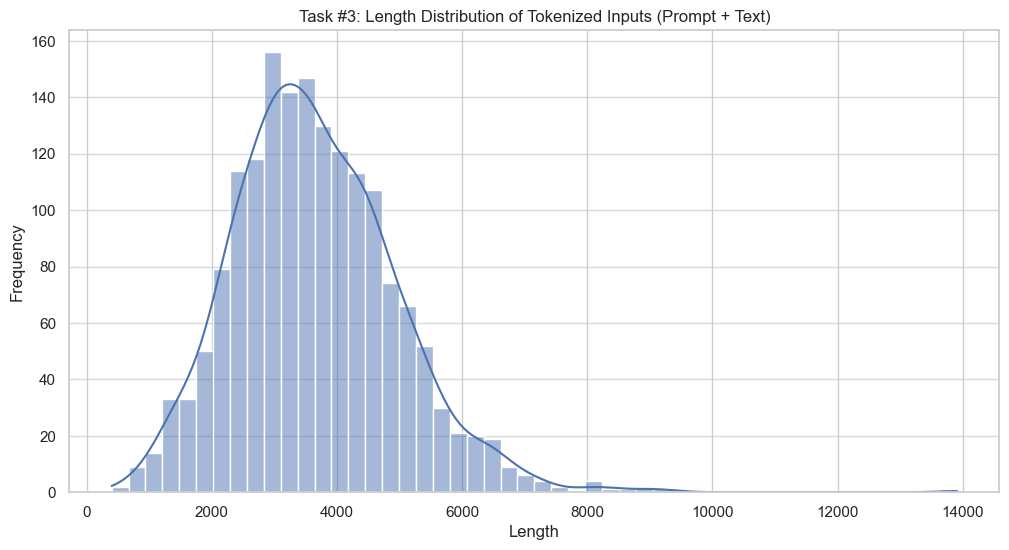

In [9]:
# PROMPT + INPUT TEXT

from transformers import AutoModelForCausalLM, AutoTokenizer

from src.prompts.summary import get_summmary_prompt
from src.data.data_manager import SummaryManager

model_path = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

dataset = SummaryManager.load_original_data()

lengths = [len(tokenizer.encode(get_summmary_prompt(example['text']))) for example in dataset['train']]
print(f"Average length: {sum(lengths)/len(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"% truncated at 256: {sum(l > 768 for l in lengths)/len(lengths):.2%}")

# plot the distibution of the lengths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(lengths, bins=50, kde=True)
plt.title("Task #3: Length Distribution of Tokenized Inputs (Prompt + Text)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [5]:
# ONLY INPUT TEXT

from transformers import AutoModelForCausalLM, AutoTokenizer

from src.prompts.summary import get_summmary_prompt
from src.data.data_manager import SummaryManager

model_path = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

dataset = SummaryManager.load_original_data()

lengths = [len(tokenizer.encode(example['text'])) for example in dataset['train']]
print(f"Average length: {sum(lengths)/len(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"% truncated at 256: {sum(l > 768 for l in lengths)/len(lengths):.2%}")

Average length: 3538.7138607971447
Max length: 13800
% truncated at 256: 99.58%


In [10]:
# ONLY TARGET OUTPUTS (Summaries)

from transformers import AutoModelForCausalLM, AutoTokenizer

from src.prompts.summary import get_summmary_prompt
from src.data.data_manager import SummaryManager

model_path = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

dataset = SummaryManager.load_original_data()

lengths = [len(tokenizer.encode(example['summary'])) for example in dataset['train']]
print(f"Average length: {sum(lengths)/len(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"% truncated at 384: {sum(l > 384 for l in lengths)/len(lengths):.2%}")

Average length: 75.08387864366449
Max length: 388
% truncated at 384: 0.06%


#### Gold Task #2

In [ ]:
# INCLUDING PROMPT

from transformers import AutoModelForCausalLM, AutoTokenizer

from src.prompts.gold import get_gold_classification_prompt
from src.data.data_manager import GoldDataManager

model_path = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

dataset = GoldDataManager.load_original_data()

lengths = [len(tokenizer.encode(get_gold_classification_prompt(example['News']))) for example in dataset['train']]
print(f"Average length: {sum(lengths)/len(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"% truncated at 768: {sum(l > 768 for l in lengths)/len(lengths):.2%}")

Average length: 709.9885208552402
Max length: 735
% truncated at 256: 0.00%


In [ ]:
# ONLY OUTPUT

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

model_path = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

example = '''{
"price_or_not": 0,
"price_up": 0,
"price_const_stable": 1,
"price_down": 1,
"past_price_info": 0,
"future_price_info": 0,
"past_gen_info": 0,
"future_gen_info": 0,'''

lengths = len(tokenizer.encode(example))
print(f"Length: {lengths}")

In [3]:
# WITHOUT PROMPT

from transformers import AutoModelForCausalLM, AutoTokenizer

from src.prompts.gold import get_gold_classification_prompt
from src.data.data_manager import GoldDataManager

model_path = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

dataset = GoldDataManager.load_original_data()

lengths = [len(tokenizer.encode(example['News'])) for example in dataset['train']]
print(f"Average length: {sum(lengths)/len(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"% truncated at 256: {sum(l > 256 for l in lengths)/len(lengths):.2%}")

Average length: 14.126883981773572
Max length: 39
% truncated at 256: 0.00%


#### Sentiment Task #1

In [ ]:
# WITHOUT PROMPT

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

model_path = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

dataset = load_dataset(path="takala/financial_phrasebank", name="sentences_50agree", trust_remote_code=True)

lengths = [len(tokenizer.encode(example['sentence'])) for example in dataset['train']]
print(f"Average length: {sum(lengths)/len(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"% truncated at 256: {sum(l > 256 for l in lengths)/len(lengths):.2%}")

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Average length: 30.292818819645067
Max length: 135
% truncated at 256: 0.00%


### Testing the outputs of different models across HF and ollama on sample prompt

In [1]:
# Untrained llama straight from hf but with KeyWordStoppingCriteria implemented in query_hf_model

from src.models.model_utils import query_with_sc
from src.prompts.sentiment import get_sentiment_prompt

from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    print(f"Tokenizer {tokenizer.name_or_path} does not have a pad token. Setting pad token to eos token.")
    tokenizer.pad_token = tokenizer.eos_token
    
    # Make sure we're setting a single integer ID
    if isinstance(model.config.eos_token_id, list):
        # If eos_token_id is a list, use the first element
        model.config.pad_token_id = model.config.eos_token_id[0]
    else:
        model.config.pad_token_id = model.config.eos_token_id
model_config = (model, tokenizer)

prompt = get_sentiment_prompt("After a long up and down, the stock market is finally on the rise, says the analyst.")

print(f"Running model {model_path} with prompt: {prompt}")
response = query_with_sc(
    model=model_config,
    prompt=prompt,
    shots=2,
    use_ollama=False,
)

response

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokenizer meta-llama/Llama-3.2-1B-Instruct does not have a pad token. Setting pad token to eos token.
Running model meta-llama/Llama-3.2-1B-Instruct with prompt: You are a highly qualified expert trained to annotate machine learning training data.

Your task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:
positive, negative, or neutral.

Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. 

Do not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral

Examples:
Text: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.
Label: positive
Text: The company generated net sales of 11.3 million euro this year.
Label: neutral
Text: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.	
Label: negative

Your TEXT to analyse:
TEXT: After a long up

'neutral'

In [1]:
# ollama llama3.2:1b

from src.models.model_utils import query_with_sc
from src.prompts.sentiment import get_sentiment_prompt

model_config = "llama3.2:1b"

prompt = get_sentiment_prompt("After a long up and down, the stock market is finally on the rise, says the analyst.")

response = query_with_sc(
    model=model_config,
    prompt=prompt,
    shots=5,
    use_ollama=True,
)

response

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Response 1:
Reponse: neutral
Cleaned response: neutral
------------
Response 2:
Reponse: neutral
Cleaned response: neutral
------------
Response 3:
Reponse: negative
Cleaned response: negative
------------
Response 4:
Reponse: negative
Cleaned response: negative
------------
Response 5:
Reponse: negative
Cleaned response: negative
------------


'negative'

In [4]:
# Untrained llama straight from hf

from src.models.model_utils import query_with_sc
from src.prompts.sentiment import get_sentiment_prompt

from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    print(f"Tokenizer {tokenizer.name_or_path} does not have a pad token. Setting pad token to eos token.")
    tokenizer.pad_token = tokenizer.eos_token
    
    # Make sure we're setting a single integer ID
    if isinstance(model.config.eos_token_id, list):
        # If eos_token_id is a list, use the first element
        model.config.pad_token_id = model.config.eos_token_id[0]
    else:
        model.config.pad_token_id = model.config.eos_token_id
model_config = (model, tokenizer)

prompt = get_sentiment_prompt("After a long up and down, the stock market is finally on the rise, says the analyst.")

print(f"Running model {model_path} with prompt: {prompt}")
response = query_with_sc(
    model=model_config,
    prompt=prompt,
    shots=2,
    use_ollama=False,
)

response

Tokenizer meta-llama/Llama-3.2-1B-Instruct does not have a pad token. Setting pad token to eos token.
Running model meta-llama/Llama-3.2-1B-Instruct with prompt: You are a highly qualified expert trained to annotate machine learning training data.

Your task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:
positive, negative, or neutral.

Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. 

Do not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral

Examples:
Text: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.
Label: positive
Text: The company generated net sales of 11.3 million euro this year.
Label: neutral
Text: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.	
Label: negative

Your TEXT to analyse:
TEXT: After a long up

'neutral'

In [ ]:
# Untrained hf base model

from src.models.model_utils import query_with_sc
from src.prompts.sentiment import get_sentiment_prompt

from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "models/sentiment:50agree/llama3.2:1b/checkpoints/dazzling-forest-66" # base model

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_config = (model, tokenizer)

prompt = get_sentiment_prompt("After a long up and down, the stock market is finally on the rise, says the analyst.")

response = query_with_sc(
    model=model_config,
    prompt=prompt,
    shots=2,
    use_ollama=False,
)

response

Response 1:
Reponse:  positive
TEXT: The company's financials are looking better, with a 10% increase in
Cleaned response: positive
------------
Response 2:
Reponse:  positive
TEXT: The company has been struggling to meet its quarterly targets, and its stock price has
Cleaned response: positive
------------


'positive'

In [ ]:
# Finetuned hf model

from src.models.model_utils import query_with_sc
from src.prompts.sentiment import get_sentiment_prompt

from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "models/sentiment:50agree/llama3.2:1b/checkpoints/smart-cosmos-63" # finetuned model

model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_config = (model, tokenizer)

prompt = get_sentiment_prompt("After a long up and down, the stock market is finally on the rise, says the analyst.")

response = query_with_sc(
    model=model_config,
    prompt=prompt,
    shots=2,
    use_ollama=False,
)

response

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Response 1:  positive
TEXT: The company's financials are looking better than expected, but the market is still
Reponse:  positive
TEXT: The company's financials are looking better than expected, but the market is still
Cleaned response: positive
------------
Response 2:  neutral
TEXT: The company has been struggling to turn a profit for several years, and the recent
Reponse:  neutral
TEXT: The company has been struggling to turn a profit for several years, and the recent
Cleaned response: neutral
------------
Response 3:  positive
TEXT: The company has been struggling to stay afloat, despite efforts to improve its financial
Reponse:  positive
TEXT: The company has been struggling to stay afloat, despite efforts to improve its financial
Cleaned response: positive
------------
Response 4:  neutral
TEXT: The company has been struggling to make ends meet, despite its efforts to increase production
Reponse:  neutral
TEXT: The company has been struggling to make ends meet, despite its effort

'neutral'

### Testing proper HF inference calls and understanding different approaches to eos and pad token config stuff

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

def query_hf_model(model_path, prompt):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Tokenize the input prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Store the input length to know where the generated text starts
    input_length = inputs.input_ids.shape[1]

    # Generate a response
    with torch.no_grad():
        outputs = model.generate(**inputs,
                                 pad_token_id=tokenizer.eos_token_id,
                                 max_new_tokens=2
                                 )

    # Decode ONLY the generated tokens (exclude the input prompt tokens)
    response = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)
    
    return response

query_hf_model("models/sentiment:50agree/llama3.2:1b/checkpoints/smart-cosmos-63", "Hello, how are you?")

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


" I've"

In [7]:
import os
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Check if a generation_config.json exists and examine it
gen_config_path = os.path.join(model_path, "generation_config.json")
if os.path.exists(gen_config_path):
    with open(gen_config_path, 'r') as f:
        gen_config = json.load(f)
        print("Current generation config:", gen_config)
        
        # Look for list parameters that should be integers
        for key, value in gen_config.items():
            if isinstance(value, list) and key in ["pad_token_id", "eos_token_id", "bos_token_id"]:
                print(f"Found list in {key}: {value}")
                # Fix by converting to integer if needed
                if value:
                    gen_config[key] = value[0]
                else:
                    gen_config[key] = None
        
        # Save the fixed config
        with open(gen_config_path + ".fixed", 'w') as f:
            json.dump(gen_config, f, indent=2)
            
        print("Fixed generation config saved to:", gen_config_path + ".fixed")

Current generation config: {'bos_token_id': 128000, 'do_sample': True, 'eos_token_id': [128001, 128008, 128009], 'temperature': 0.6, 'top_p': 0.9, 'transformers_version': '4.49.0'}
Found list in eos_token_id: [128001, 128008, 128009]
Fixed generation config saved to: models/sentiment:50agree/llama3.2:1b/checkpoints/sparkling-waterfall-43/generation_config.json.fixed


### Test SentimentDataManager class

In [1]:
from src.data.data_manager import SentimentDataManager

SentimentDataManager.save_model_outputs(
    ["hello"],
    ["positive"],
    ["neutral"],
    "sentiment:50agree",
    "smollm2:135m",
    "test123"
)

/Users/hendriksippel/Documents/Repositories/cbs-thesis-efficient-llm-distillation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created directory models/sentiment:50agree/smollm2:135m/inference_outputs/test123.


Saving the dataset (1/1 shards): 100%|██████████| 1/1 [00:00<00:00, 140.76 examples/s]


In [3]:
from datasets import load_from_disk

dataset = load_from_disk("models/sentiment:50agree/smollm2:135m/inference_outputs/elated-grass-15")

print("Dataset structure")
print(dataset)

print("First row")
print(dataset[0])

Dataset structure
Dataset({
    features: ['prompt', 'true_label', 'completion'],
    num_rows: 10
})
First row
{'prompt': 'You are a highly qualified expert trained to annotate machine learning training data.\n\nYour task is to analyze the sentiment in the TEXT below from an investor perspective and label it with only one the three labels:\npositive, negative, or neutral.\n\nBase your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about a company. \n\nDo not provide any explanations and only respond with one of the labels as one word: negative, positive, or neutral\n\nExamples:\nText: Operating profit increased, from EUR 7m to 9m compared to the previous reporting period.\nLabel: positive\nText: The company generated net sales of 11.3 million euro this year.\nLabel: neutral\nText: Profit before taxes decreased to EUR 14m, compared to EUR 19m in the previous period.\t\nLabel: negative\n\nYour TEXT to analyse:\nTEXT: Sanoma Magazines International wil

In [8]:
from src.data.process_datasets import get_processed_hf_dataset

sentences, true_labels = get_processed_hf_dataset(dataset="sentiment", split_mode="none")

Loaded dataset sentences_50agree with 4846 training samples.


### Experimenting with PEFT LoRA stuff

In [ ]:
from src.models.hf_utils import load_model_from_hf

from peft import LoraConfig, TaskType, get_peft_model

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=16,
    lora_dropout=0.1
)

model, tokenizer = load_model_from_hf("llama3.2:1b")

peft_model = get_peft_model(model, peft_config)

peft_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


In [16]:
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

chat1 = [
    {"role": "user", "content": "Which is bigger, the moon or the sun?"},
    {"role": "assistant", "content": "The sun."}
]
chat2 = [
    {"role": "user", "content": "Which is bigger, a virus or a bacterium?"},
    {"role": "assistant", "content": "A bacterium."}
]

dataset = Dataset.from_dict({"chat": [chat1, chat2]})
dataset = dataset.map(lambda x: {"formatted_chat": tokenizer.apply_chat_template(x["chat"], tokenize=False, add_generation_prompt=False)})
print(dataset['formatted_chat'][0])

Map: 100%|██████████| 2/2 [00:00<00:00, 45.87 examples/s]

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 25 Mar 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

Which is bigger, the moon or the sun?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The sun.<|eot_id|>
